In [1]:
# pip install pandas scikit-learn matplotlib

In [2]:
from pathlib import Path
import os

import utils as u

In [3]:
notebook_path = Path(os.path.abspath("."))
data_path = notebook_path.parent / "docs" / "data"

# EVALUATION

## NHL

In [4]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nhl", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=6.5, hcp_line=1.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,2025020158,2025-10-29T00:15:00,St. Louis Blues,Detroit Red Wings,0.5611,0.4040,0.7829,2,5,False,True,False
1,2025020076,2025-10-18T17:00:00,Buffalo Sabres,Florida Panthers,0.5602,0.4793,0.7733,3,0,True,False,True


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          252      0.5238 0.2578   0.7099 0.5070   0.5198
Totals (Over/Under)  252      0.4881 0.2503   0.6938 0.5195   0.5278
Asian Handicap       252      0.7579 0.1881   0.5663 0.5151   0.7540


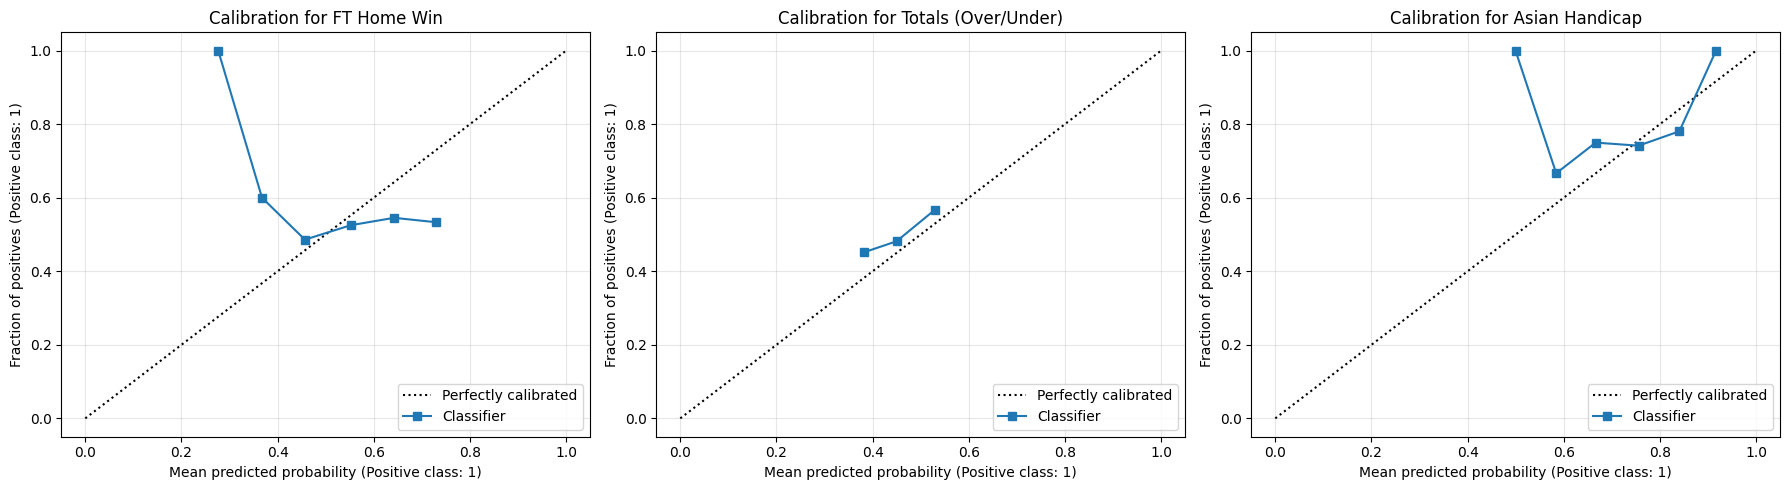

In [5]:
# Evaluate everything
_ = u.evaluate_calibration(df=df, n_bins=10)

=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          112      0.5179 0.2547   0.7026 0.5437   0.5179
Totals (Over/Under)  112      0.5089 0.2502   0.6935 0.5365   0.4911
Asian Handicap       112      0.7589 0.1926   0.5753 0.4780   0.7500


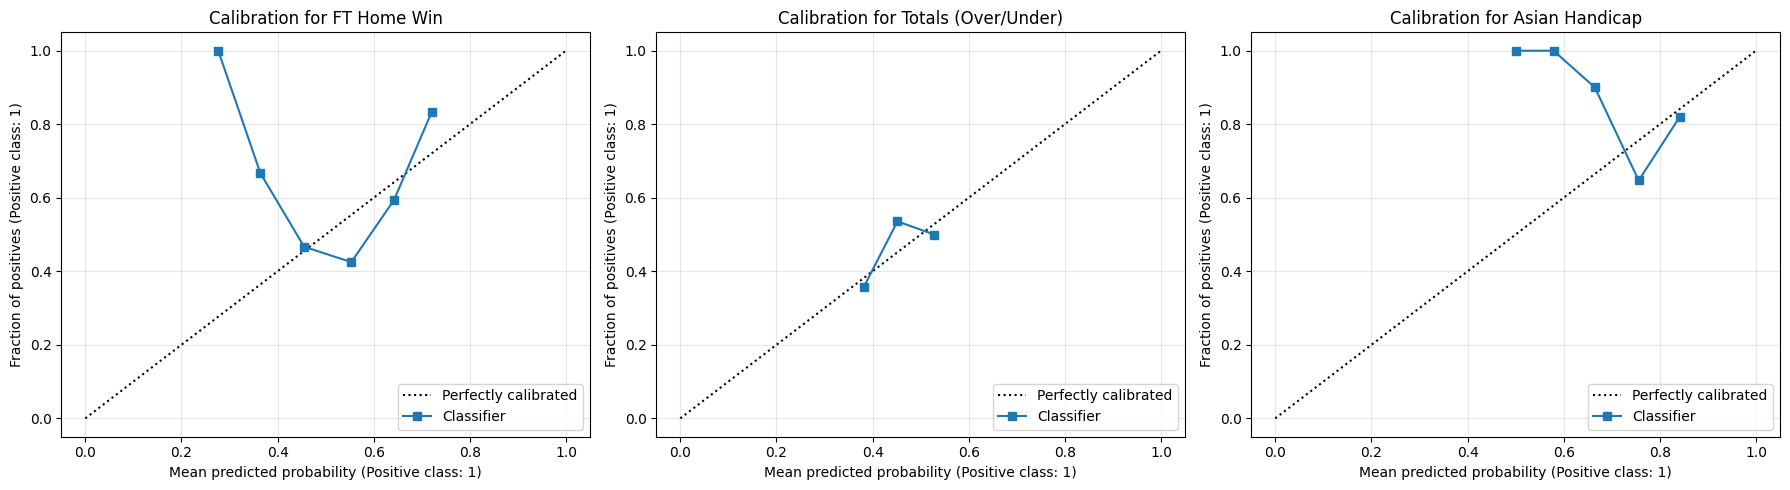

In [6]:
# Evaluate matches only after major bugfix
after_bug_df = df[df["start_time_utc"]>="2025-10-29 15:00:00"].copy()
_ = u.evaluate_calibration(df=after_bug_df, n_bins=10)

## NBA

In [ ]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nba", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=225.5, hcp_line=-8.5)
df.head(2)

In [ ]:
_ = u.evaluate_calibration(df=df, n_bins=10)

Not enough samples
